In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import csv
import numpy as np
import os
import math
import glob
import json
import glob
import seaborn as sns
import time
import shutil
import copy
from collections import defaultdict
from sklearn import linear_model
from torch import tensor
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output
import sys
sys.path.insert(0, '/home/caitao/Project/dl-localization')
from input_output import Default
from utility import Utility
from torch._six import container_abcs, string_classes, int_classes
import re
from scipy.ndimage import gaussian_filter
np_str_obj_array_pattern = re.compile(r'[SaUO]')
default_collate_err_msg_format = (
    "default_collate: batch must contain tensors, numpy arrays, numbers, "
    "dicts or lists; found {}")

# 1 Common Modules

In [2]:
class UniformNormalize:
    '''Set a uniform threshold accross all samples
    '''
    def __init__(self, noise_floor):
        self.noise_floor = noise_floor

    def __call__(self, matrix):
        matrix -= self.noise_floor
        matrix /= (-self.noise_floor/2)
        return matrix.astype(np.float32)

# 2 Dataset

matrix shape: torch.Size([1, 21, 21])
target: [10.881085 25.018679]
target: [23.534641 31.282738]
data size: 118043
[[19.876255  30.203094   3.3098257]]
[[10.269001  31.63292    4.7922883]
 [43.395325  40.10375    1.0607997]
 [29.119146  19.922602   5.053936 ]]


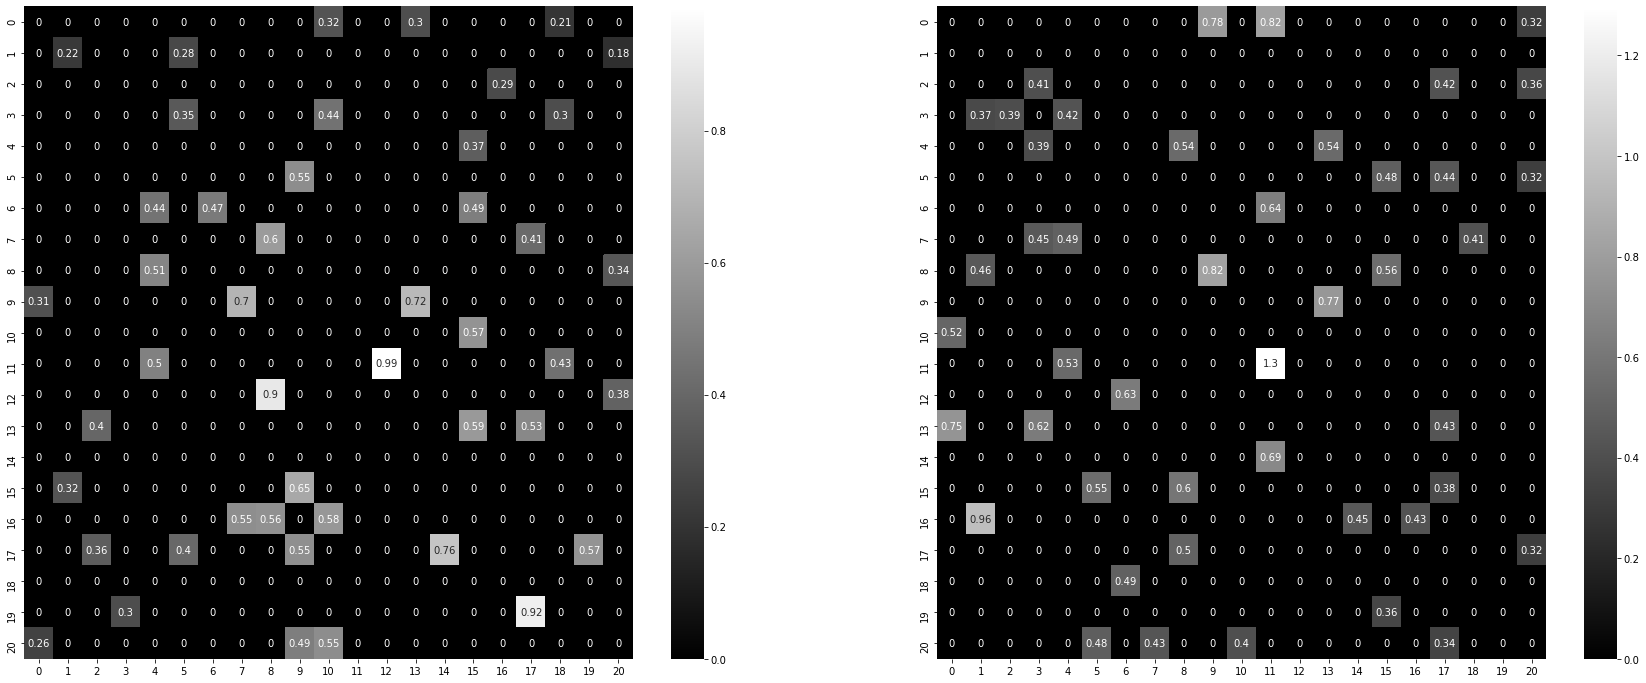

In [3]:
class SensorInputDataset(Dataset):
    '''Sensor reading input dataset -- for single TX power estimation
       output is a scaler value
    '''
    def __init__(self, root_dir: str, transform=None):
        '''
        Args:
            root_dir: directory
        '''
        self.root_dir = root_dir
        self.transform = transform
        self.length = len(os.listdir(self.root_dir))
        
    def __len__(self):
        return int(self.length / 4)

    def __getitem__(self, idx):
        matrix_name = f'{idx}.npy'
        matrix_path = os.path.join(self.root_dir, matrix_name)
        power_name = f'{idx}.power.npy'
        power_path = os.path.join(self.root_dir, power_name)
        target_name = f'{idx}.target.npy'
        target_path = os.path.join(self.root_dir, target_name)
        closeby_name = f'{idx}.closeby.npy'
        closeby_path = os.path.join(self.root_dir, closeby_name)
        matrix = np.load(matrix_path)
        power = np.load(power_path)
        target = np.load(target_path)
        closeby = np.load(closeby_path)
        if self.transform:
            matrix = self.transform(matrix)
        sample = {'index': idx, 'matrix': matrix, 'power': power, 'target': target, 'closeby': closeby}
        return sample


# BUG: referance, directly transform and update that object referred in memory. that cropping [a:b, c:d] is also reference only
tf = T.Compose([
    UniformNormalize(Default.noise_floor),
    T.ToTensor()]
)


i, j = 300, 408
root_dir = './data/805test_crop_multi_radius20_pro'
# root_dir = './data/805test_crop_single'
train_sensor_input_dataset = SensorInputDataset(root_dir=root_dir, transform=tf)
train_sensor_input_dataloader = DataLoader(train_sensor_input_dataset, batch_size=16, shuffle=True, num_workers=3)
print('matrix shape:', train_sensor_input_dataset[i]['matrix'].shape)
print('target:', train_sensor_input_dataset[i]['target'])
print('target:', train_sensor_input_dataset[j]['target'])
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(30, 12))
sns.heatmap(train_sensor_input_dataset[i]['matrix'][0], annot=True, ax=ax0, cmap='gray')
sns.heatmap(train_sensor_input_dataset[j]['matrix'][0], annot=True, ax=ax1, cmap='gray')
print('data size:', train_sensor_input_dataset.__len__())
print(train_sensor_input_dataset[i]['closeby'])
print(train_sensor_input_dataset[j]['closeby'])

# root_dir = './data/605test_crop'
# root_dir = './data/805test_crop_single'
# test_sensor_input_dataset = SensorInputDataset(root_dir=root_dir, transform=tf)
# test_sensor_input_dataloader = DataLoader(test_sensor_input_dataset, batch_size=16, shuffle=True, num_workers=3)
# print('matrix shape:', test_sensor_input_dataset[j]['matrix'].shape)
# print('target:', test_sensor_input_dataset[i]['target'])
# print('target:', test_sensor_input_dataset[j]['target'])
# fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(30, 12))
# sns.heatmap(test_sensor_input_dataset[i]['matrix'][0], annot=True, ax=ax0, cmap='gray')
# sns.heatmap(test_sensor_input_dataset[j]['matrix'][0], annot=True, ax=ax1, cmap='gray')

# 3 Model

In [4]:
class PowerPredictor(nn.Module):
    '''The input is 1 x 21 x 21
       the output is a scaler between 0 and 5
    '''
    def __init__(self):
        super(PowerPredictor, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5)
        self.conv2 = nn.Conv2d(4, 16, 5)
        self.conv3 = nn.Conv2d(16, 64, 5)
        self.conv4 = nn.Conv2d(64, 256, 5)
        self.conv5 = nn.Conv2d(256, 256, 5)
        self.fc = nn.Linear(256, 1)
        self.norm1 = nn.GroupNorm(2, 4)
        self.norm2 = nn.GroupNorm(8, 16)
        self.norm3 = nn.GroupNorm(32, 64)
        self.norm4 = nn.GroupNorm(128, 256)
        self.norm5 = nn.GroupNorm(128, 256)
    
    def forward(self, x):
        x = F.relu(self.norm1(self.conv1(x)))
        x = F.relu(self.norm2(self.conv2(x)))
        x = F.relu(self.norm3(self.conv3(x)))
        x = F.relu(self.norm4(self.conv4(x)))
        x = F.relu(self.norm5(self.conv5(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

model = PowerPredictor()
print(model)

PowerPredictor(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (norm1): GroupNorm(2, 4, eps=1e-05, affine=True)
  (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
  (norm3): GroupNorm(32, 64, eps=1e-05, affine=True)
  (norm4): GroupNorm(128, 256, eps=1e-05, affine=True)
  (norm5): GroupNorm(128, 256, eps=1e-05, affine=True)
)


In [109]:
class PowerPredictor2(nn.Module):
    '''The input is 1 x 21 x 21
       the output is a scaler between 0 and 5
    '''
    def __init__(self):
        super(PowerPredictor2, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5)
        self.conv2 = nn.Conv2d(4, 16, 5)
        self.conv3 = nn.Conv2d(16, 64, 5)
        self.conv4 = nn.Conv2d(64, 256, 5)
        self.conv5 = nn.Conv2d(256, 256, 5)
        self.fc = nn.Linear(256, 1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

model = PowerPredictor2()
print(model)

PowerPredictor2(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [111]:
class PowerPredictor3(nn.Module):
    '''The input is 1 x 21 x 21
       the output is a scaler between 0 and 5
    '''
    def __init__(self):
        super(PowerPredictor3, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5)
        self.conv2 = nn.Conv2d(4, 16, 5)
        self.conv3 = nn.Conv2d(16, 64, 5)
        self.conv4 = nn.Conv2d(64, 256, 5)
        self.conv5 = nn.Conv2d(256, 256, 5)
        self.fc = nn.Linear(256, 1)
        self.norm1 = nn.GroupNorm(2, 4)
        self.norm2 = nn.GroupNorm(8, 16)
    
    def forward(self, x):
        x = F.relu(self.norm1(self.conv1(x)))
        x = F.relu(self.norm2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

model = PowerPredictor3()
print(model)

PowerPredictor3(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (norm1): GroupNorm(2, 4, eps=1e-05, affine=True)
  (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
)


In [136]:
class PowerPredictor4(nn.Module):
    '''The input is 1 x 21 x 21, the output is a scaler between 0.5 and 5.5
       No fully connected layer in the end
    '''
    def __init__(self):
        super(PowerPredictor4, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 128, 5)
        self.conv3 = nn.Conv2d(128, 32, 5)
        self.conv4 = nn.Conv2d(32, 8, 5)
        self.conv5 = nn.Conv2d(8, 1, 5)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        x = x.view(-1, self.num_flat_features(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    
model = PowerPredictor4()
device = torch.device('cuda')
sample = train_sensor_input_dataset[0]
X = torch.as_tensor(sample['matrix'])
X = X.unsqueeze(0)
y = sample['target']
y_pred = model(X)
y_pred = y_pred.data.cpu().numpy()
print('pred', y_pred)
print('model', model)

pred [[0.05998106]]
model PowerPredictor4(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(128, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(32, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(8, 1, kernel_size=(5, 5), stride=(1, 1))
)


In [4]:
class PowerPredictor5(nn.Module):
    '''The input is 1 x 21 x 21, the output is a scaler between 0.5 and 5.5
       No fully connected layer in the end
       
       The CHOSEN one.
    '''
    def __init__(self):
        super(PowerPredictor5, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 128, 5)
        self.conv3 = nn.Conv2d(128, 32, 5)
        self.conv4 = nn.Conv2d(32, 8, 5)
        self.conv5 = nn.Conv2d(8, 1, 5)
        self.norm1 = nn.BatchNorm2d(32)
        self.norm2 = nn.BatchNorm2d(128)
        self.norm3 = nn.BatchNorm2d(32)
        self.norm4 = nn.BatchNorm2d(8)
    
    def forward(self, x):
        x = F.relu(self.norm1(self.conv1(x)))
        x = F.relu(self.norm2(self.conv2(x)))
        x = F.relu(self.norm3(self.conv3(x)))
        x = F.relu(self.norm4(self.conv4(x)))
        x = self.conv5(x)
        x = x.view(-1, self.num_flat_features(x))
        return x

    def num_flat_features(self, x):
        
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


model = PowerPredictor5()
device = torch.device('cuda')
sample = train_sensor_input_dataset[0]
X = torch.as_tensor(sample['matrix'])
print(X.shape)
X = X.unsqueeze(0)
print(X.shape)
y = sample['target']
y_pred = model(X)
y_pred = y_pred.data.cpu().numpy()
print('pred', y_pred)
print('model', model)

torch.Size([1, 21, 21])
torch.Size([1, 1, 21, 21])
pred [[0.27199104]]
model PowerPredictor5(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(128, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(32, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(8, 1, kernel_size=(5, 5), stride=(1, 1))
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [292]:
class PowerPredictor6(nn.Module):
    '''The input is 1 x 21 x 21, the output is a scaler between 0.5 and 5.5
       No fully connected layer in the end
    '''
    def __init__(self):
        super(PowerPredictor6, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 32, 5)
        self.conv3 = nn.Conv2d(32, 32, 5)
        self.conv4 = nn.Conv2d(32, 8, 5)
        self.conv5 = nn.Conv2d(8, 1, 5)
        self.norm1 = nn.BatchNorm2d(8)
        self.norm2 = nn.BatchNorm2d(32)
        self.norm3 = nn.BatchNorm2d(32)
        self.norm4 = nn.BatchNorm2d(8)
    
    def forward(self, x):
        x = F.relu(self.norm1(self.conv1(x)))
        x = F.relu(self.norm2(self.conv2(x)))
        x = F.relu(self.norm3(self.conv3(x)))
        x = F.relu(self.norm4(self.conv4(x)))
        x = self.conv5(x)
        x = x.view(-1, self.num_flat_features(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


model = PowerPredictor6()
device = torch.device('cuda')
sample = train_sensor_input_dataset[0]
X = torch.as_tensor(sample['matrix'])
X = X.unsqueeze(0)
y = sample['target']
y_pred = model(X)
y_pred = y_pred.data.cpu().numpy()
print('pred', y_pred)
print('model', model)

pred [[-0.14333035]]
model PowerPredictor6(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(32, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(8, 1, kernel_size=(5, 5), stride=(1, 1))
  (norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


# 4 Training

## 4.1 PowerPredictor

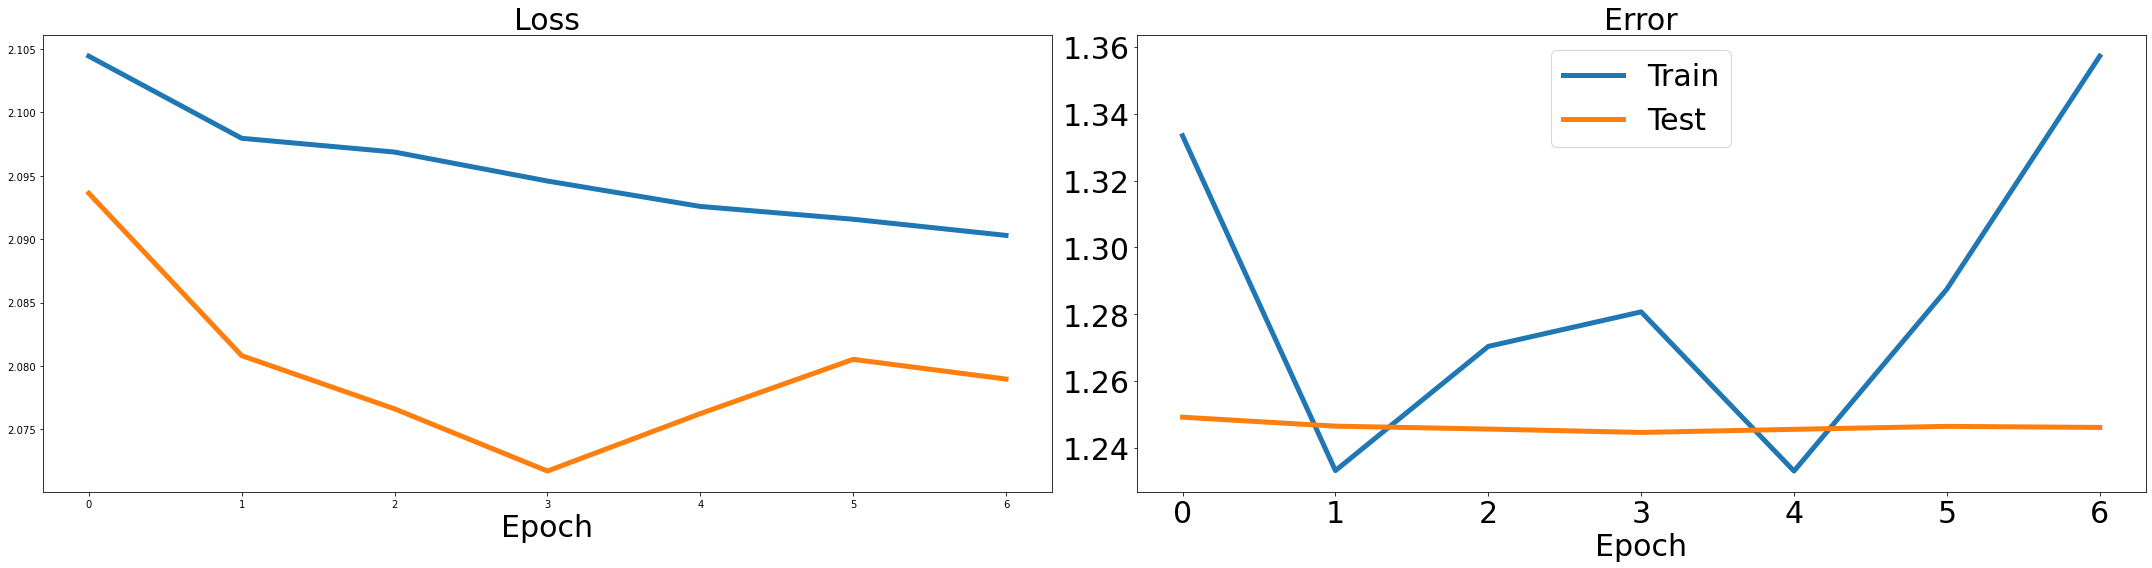

epoch = 7
t = 0, loss = 1.6019213199615479, error = 1.020113468170166
t = 200, loss = 1.9428584575653076, error = 1.1765817403793335
t = 400, loss = 2.0497143268585205, error = 1.2540779113769531
t = 600, loss = 2.064540386199951, error = 1.2209186553955078
t = 800, loss = 1.3202760219573975, error = 0.9960464239120483
t = 1000, loss = 1.498389720916748, error = 0.9481837749481201


KeyboardInterrupt: 

In [175]:
device = torch.device('cuda')
model = PowerPredictor()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print_every = 200
train_losses_epoch, train_errors_epoch = [], []
test_losses_epoch,  test_errors_epoch  = [], []

num_epochs = 20
for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses, train_errors = [], []
    test_losses, test_errors = [], []
    model.train()
    for t, sample in enumerate(train_sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        
        y_pred = model(X)
        
        loss = loss_func(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        if t % print_every == 0:
            y_pred = y_pred.data.cpu().numpy()
            errors = list(np.absolute(y_pred - np.array(sample['target'])))
            train_errors.extend(errors)
            print(f't = {t}, loss = {loss.item()}, error = {np.average(errors)}')
    
    model.eval()
    for t, sample in enumerate(test_sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        
        y_pred = model(X)
        
        loss = loss_func(y_pred, y)
        test_losses.append(loss.item())
        y_pred = y_pred.data.cpu().numpy()
        errors = list(np.absolute(y_pred - np.array(sample['target'])))
        test_errors.extend(errors)
    
    scheduler.step()
    
    clear_output(True)
    train_losses_epoch.append(np.mean(train_losses))
    train_errors_epoch.append(np.mean(train_errors))
    test_losses_epoch.append(np.mean(test_losses))
    test_errors_epoch.append(np.mean(test_errors))
    plt.figure(figsize=(30, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_losses_epoch, label='Train', linewidth=5)
    plt.plot(test_losses_epoch, label='Test', linewidth=5)
    plt.subplot(1, 2, 2)
    plt.title('Error', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_errors_epoch, label='Train', linewidth=5)
    plt.plot(test_errors_epoch, label='Test', linewidth=5)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=30)
    plt.tight_layout()
    plt.show()

## 4.2 PowerPredictor2

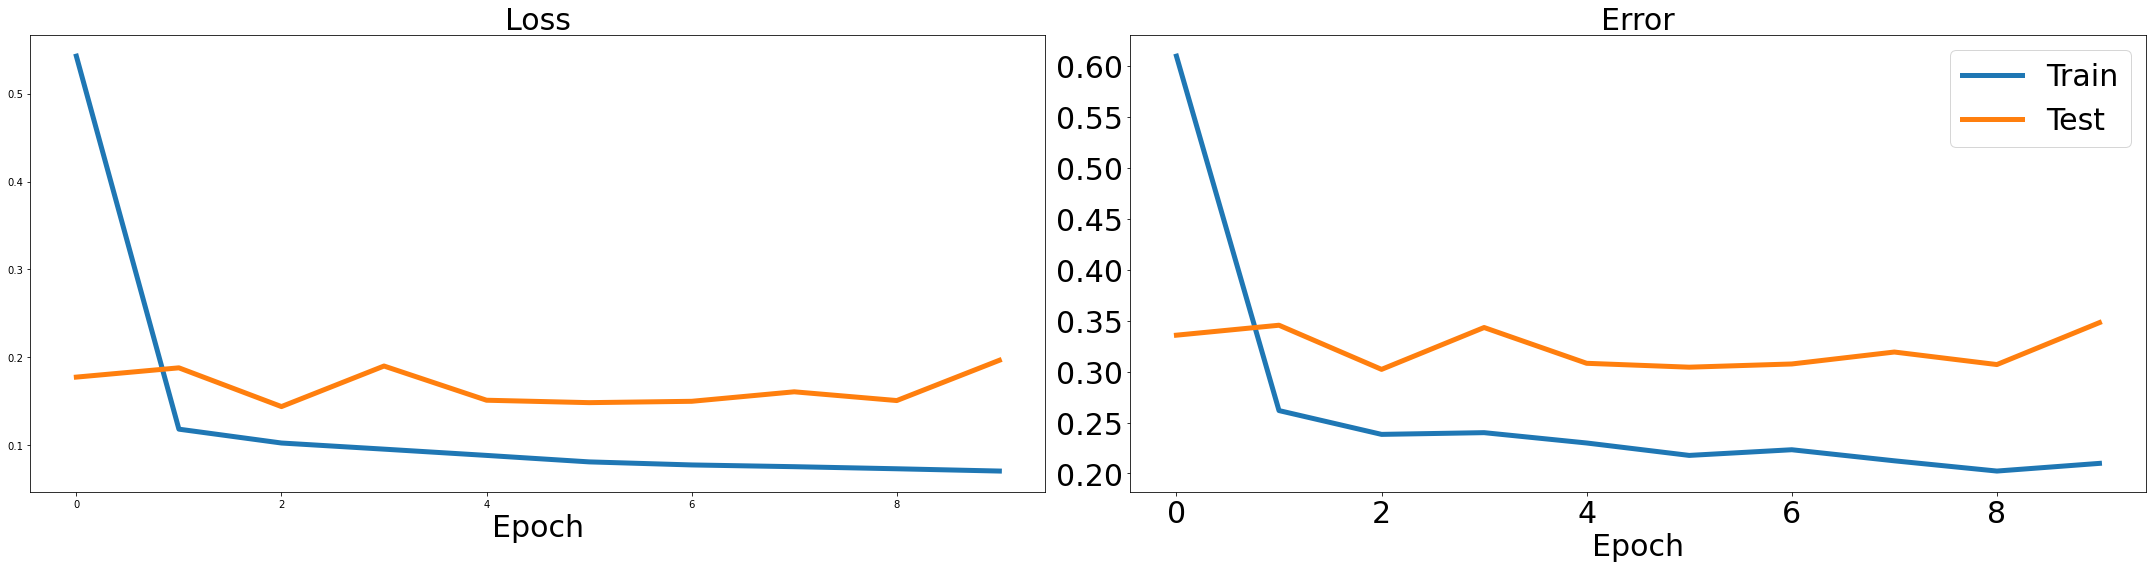

In [177]:
device = torch.device('cuda')
model = PowerPredictor2()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

print_every = 200
train_losses_epoch, train_errors_epoch = [], []
test_losses_epoch,  test_errors_epoch  = [], []

num_epochs = 10
for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses, train_errors = [], []
    test_losses, test_errors = [], []
    model.train()
    for t, sample in enumerate(train_sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        
        y_pred = model(X)
        
        loss = loss_func(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        if t % print_every == 0:
            y_pred = y_pred.data.cpu().numpy()
            errors = list(np.absolute(y_pred - np.array(sample['target'])))
            train_errors.extend(errors)
            print(f't = {t}, loss = {loss.item()}, error = {np.average(errors)}')
    
    model.eval()
    for t, sample in enumerate(test_sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        
        y_pred = model(X)
        
        loss = loss_func(y_pred, y)
        test_losses.append(loss.item())
        y_pred = y_pred.data.cpu().numpy()
        errors = list(np.absolute(y_pred - np.array(sample['target'])))
        test_errors.extend(errors)
    
    scheduler.step()
    
    clear_output(True)
    train_losses_epoch.append(np.mean(train_losses))
    train_errors_epoch.append(np.mean(train_errors))
    test_losses_epoch.append(np.mean(test_losses))
    test_errors_epoch.append(np.mean(test_errors))
    plt.figure(figsize=(30, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_losses_epoch, label='Train', linewidth=5)
    plt.plot(test_losses_epoch, label='Test', linewidth=5)
    plt.subplot(1, 2, 2)
    plt.title('Error', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_errors_epoch, label='Train', linewidth=5)
    plt.plot(test_errors_epoch, label='Test', linewidth=5)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=30)
    plt.tight_layout()
    plt.show()

## 4.3 PowerPredictor3

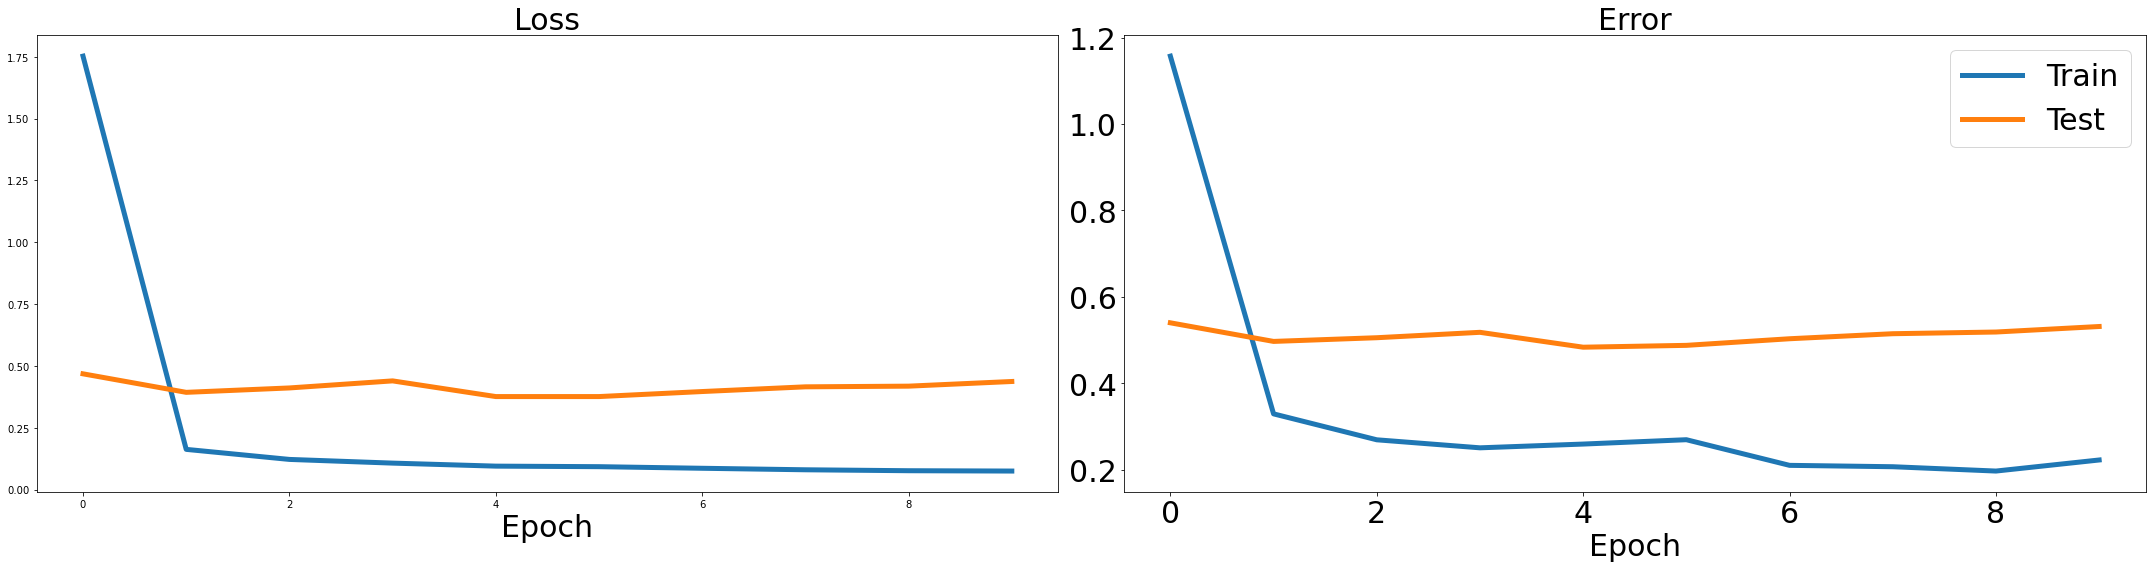

In [181]:
device = torch.device('cuda')
model = PowerPredictor3()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

print_every = 200
train_losses_epoch, train_errors_epoch = [], []
test_losses_epoch,  test_errors_epoch  = [], []

num_epochs = 10
for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses, train_errors = [], []
    test_losses, test_errors = [], []
    model.train()
    for t, sample in enumerate(train_sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        
        y_pred = model(X)
        
        loss = loss_func(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        if t % print_every == 0:
            y_pred = y_pred.data.cpu().numpy()
            errors = list(np.absolute(y_pred - np.array(sample['target'])))
            train_errors.extend(errors)
            print(f't = {t}, loss = {loss.item()}, error = {np.average(errors)}')
    
    model.eval()
    for t, sample in enumerate(test_sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        
        y_pred = model(X)
        
        loss = loss_func(y_pred, y)
        test_losses.append(loss.item())
        y_pred = y_pred.data.cpu().numpy()
        errors = list(np.absolute(y_pred - np.array(sample['target'])))
        test_errors.extend(errors)
    
    scheduler.step()
    
    clear_output(True)
    train_losses_epoch.append(np.mean(train_losses))
    train_errors_epoch.append(np.mean(train_errors))
    test_losses_epoch.append(np.mean(test_losses))
    test_errors_epoch.append(np.mean(test_errors))
    plt.figure(figsize=(30, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_losses_epoch, label='Train', linewidth=5)
    plt.plot(test_losses_epoch, label='Test', linewidth=5)
    plt.subplot(1, 2, 2)
    plt.title('Error', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_errors_epoch, label='Train', linewidth=5)
    plt.plot(test_errors_epoch, label='Test', linewidth=5)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=30)
    plt.tight_layout()
    plt.show()

## 4.4 PowerPredictor4

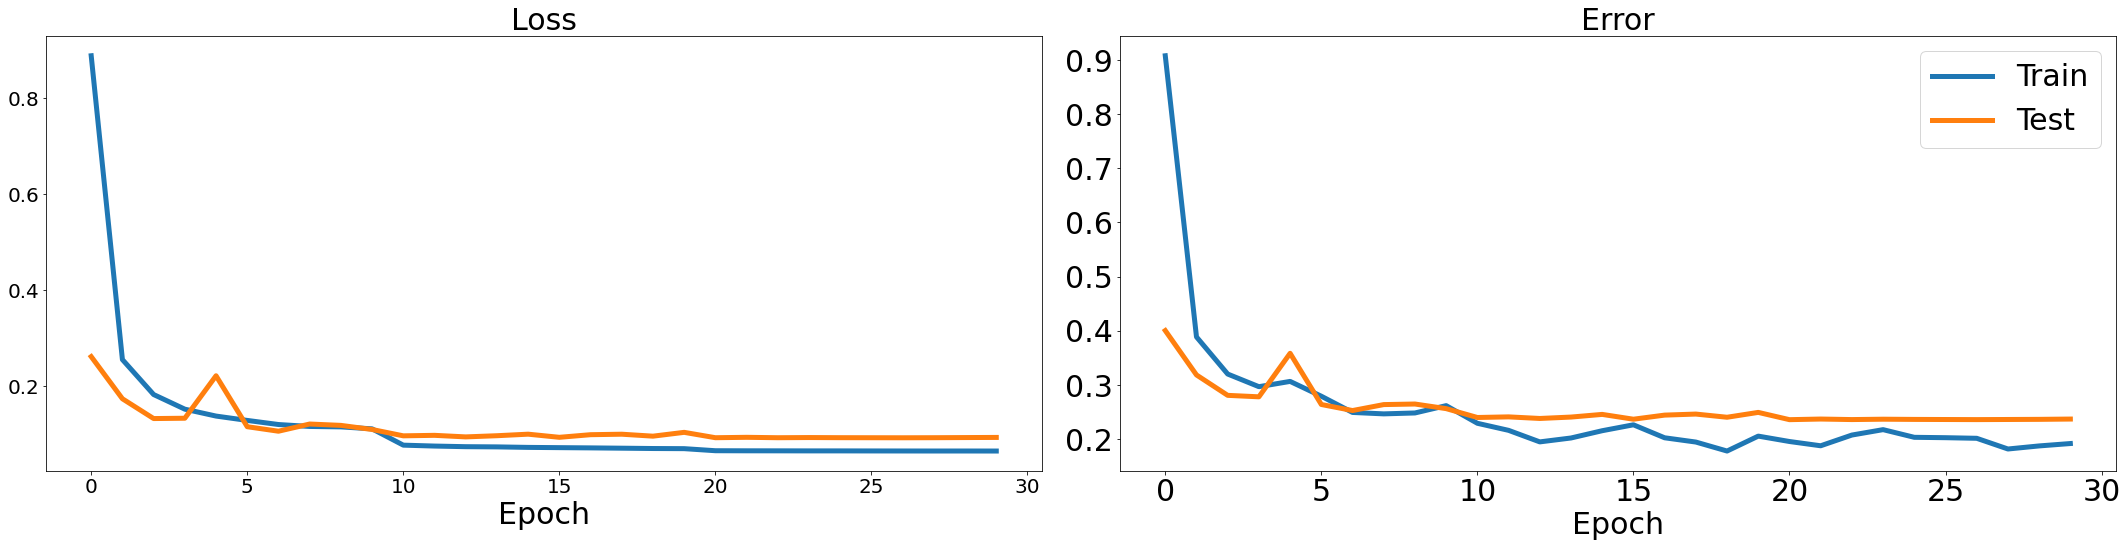

In [290]:
device = torch.device('cuda')
model = PowerPredictor4()
model_path = 'model/predictor4-9.24-{}.pt'

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print_every = 200
train_losses_epoch, train_errors_epoch = [], []
test_losses_epoch,  test_errors_epoch  = [], []
min_loss = 1000

num_epochs = 30
for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses, train_errors = [], []
    test_losses, test_errors = [], []
    model.train()
    for t, sample in enumerate(train_sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        
        y_pred = model(X)
        
        loss = loss_func(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        if t % print_every == 0:
            y_pred = y_pred.data.cpu().numpy()
            errors = list(np.absolute(y_pred - np.array(sample['target'])))
            train_errors.extend(errors)
            print(f't = {t}, loss = {loss.item()}, error = {np.average(errors)}')
    
    model.eval()
    for t, sample in enumerate(test_sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        
        y_pred = model(X)
        
        loss = loss_func(y_pred, y)
        test_losses.append(loss.item())
        y_pred = y_pred.data.cpu().numpy()
        errors = list(np.absolute(y_pred - np.array(sample['target'])))
        test_errors.extend(errors)
    
    new_mean = np.mean(test_errors)
    if new_mean < min_loss:
        torch.save(model.state_dict(), model_path.format(f'{new_mean:.4}'))
        min_loss = new_mean
    
    scheduler.step()
    
    clear_output(True)
    train_losses_epoch.append(np.mean(train_losses))
    train_errors_epoch.append(np.mean(train_errors))
    test_losses_epoch.append(np.mean(test_losses))
    test_errors_epoch.append(np.mean(test_errors))
    plt.figure(figsize=(30, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_losses_epoch, label='Train', linewidth=5)
    plt.plot(test_losses_epoch, label='Test', linewidth=5)
    plt.subplot(1, 2, 2)
    plt.title('Error', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_errors_epoch, label='Train', linewidth=5)
    plt.plot(test_errors_epoch, label='Test', linewidth=5)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=30)
    plt.tight_layout()
    plt.show()

In [289]:
test_errors_epoch

[0.36079833,
 0.31492668,
 0.28322414,
 0.3041515,
 0.26023358,
 0.2698644,
 0.2766043,
 0.3045719,
 0.2487268,
 0.24750246,
 0.2432027,
 0.25327656,
 0.24070047,
 0.2395941,
 0.23808847,
 0.23853923,
 0.23961344,
 0.23854865,
 0.23755035,
 0.23774913,
 0.23642221,
 0.23684731,
 0.23629814,
 0.23632194,
 0.23719254,
 0.23619199,
 0.23623037,
 0.23687561,
 0.23715389,
 0.23737432]

## 4.5 PowerPredictor5

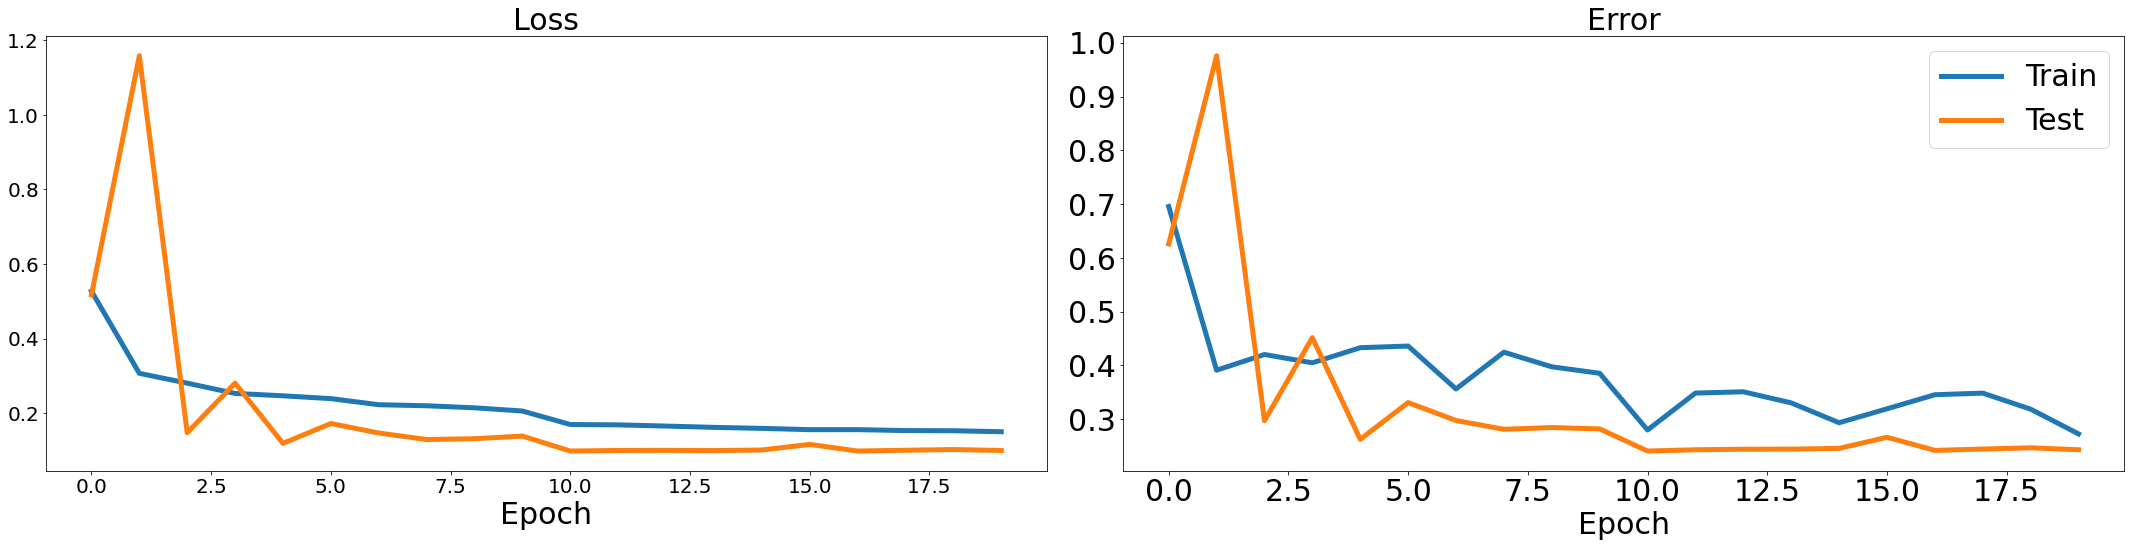

In [325]:
device = torch.device('cuda')
model = PowerPredictor5()
model_path = 'model/predictor5-9.25-{}.pt'

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print_every = 200
train_losses_epoch, train_errors_epoch = [], []
test_losses_epoch,  test_errors_epoch  = [], []
min_loss = 1000

num_epochs = 20
for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses, train_errors = [], []
    test_losses, test_errors = [], []
    model.train()
    for t, sample in enumerate(train_sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['power'].to(device)
        
        y_pred = model(X)
        
        loss = loss_func(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        if t % print_every == 0:
            y_pred = y_pred.data.cpu().numpy()
            errors = list(np.absolute(y_pred - np.array(sample['target'])))
            train_errors.extend(errors)
            print(f't = {t}, loss = {loss.item()}, error = {np.average(errors)}')
    
    model.eval()
    for t, sample in enumerate(test_sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['power'].to(device)
        
        y_pred = model(X)
        
        loss = loss_func(y_pred, y)
        test_losses.append(loss.item())
        y_pred = y_pred.data.cpu().numpy()
        errors = list(np.absolute(y_pred - np.array(sample['target'])))
        test_errors.extend(errors)
    
    new_mean = np.mean(test_errors)
    if new_mean < min_loss:
        torch.save(model.state_dict(), model_path.format(f'{new_mean:.4}'))
        min_loss = new_mean
    
    scheduler.step()
    
    clear_output(True)
    train_losses_epoch.append(np.mean(train_losses))
    train_errors_epoch.append(np.mean(train_errors))
    test_losses_epoch.append(np.mean(test_losses))
    test_errors_epoch.append(np.mean(test_errors))
    plt.figure(figsize=(30, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_losses_epoch, label='Train', linewidth=5)
    plt.plot(test_losses_epoch, label='Test', linewidth=5)
    plt.subplot(1, 2, 2)
    plt.title('Error', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_errors_epoch, label='Train', linewidth=5)
    plt.plot(test_errors_epoch, label='Test', linewidth=5)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=30)
    plt.tight_layout()
    plt.show()

## 4.6 PowerPredictor6

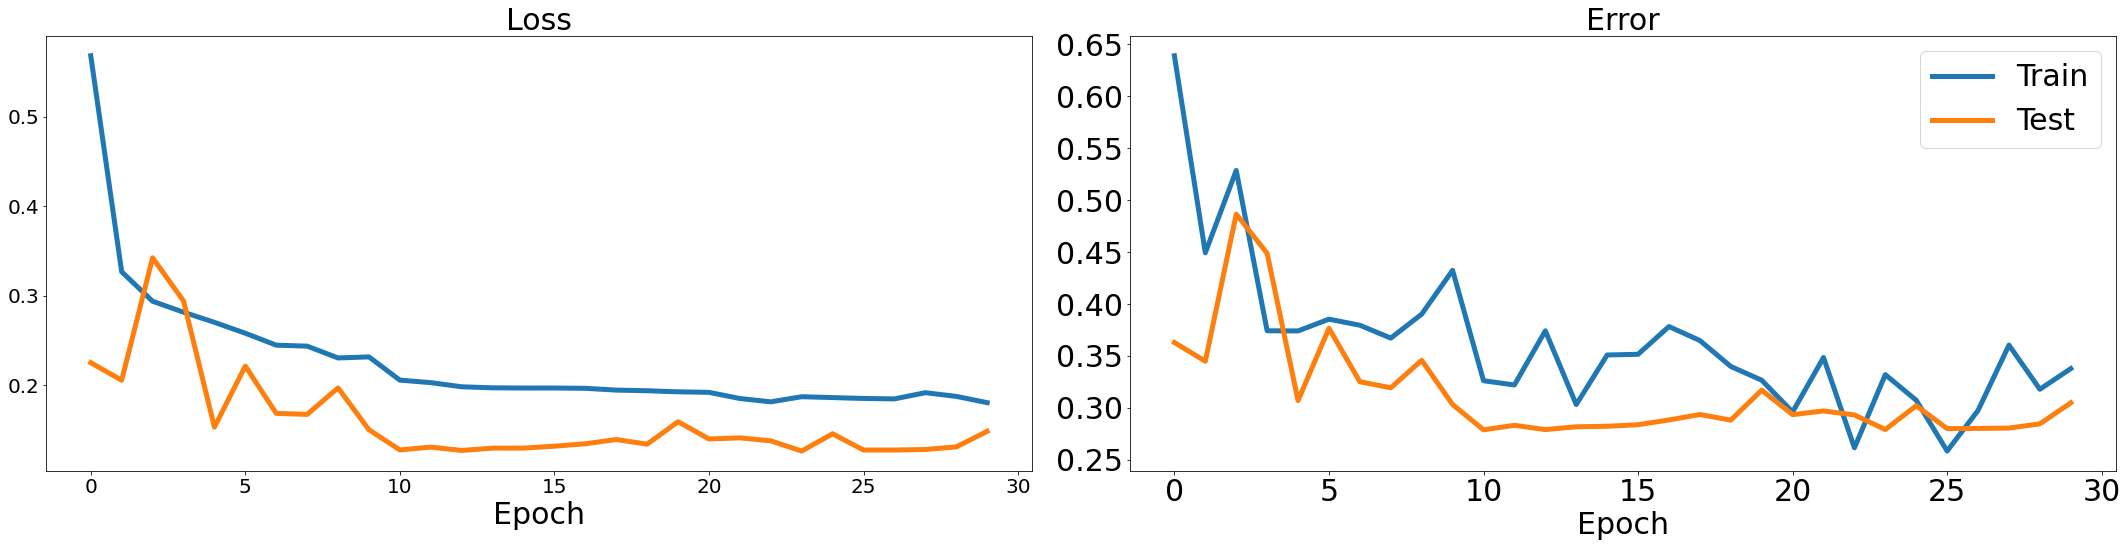

In [294]:
device = torch.device('cuda')
model = PowerPredictor6()
model_path = 'model/predictor6-9.24-{}.pt'

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print_every = 200
train_losses_epoch, train_errors_epoch = [], []
test_losses_epoch,  test_errors_epoch  = [], []
min_loss = 1000

num_epochs = 30
for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses, train_errors = [], []
    test_losses, test_errors = [], []
    model.train()
    for t, sample in enumerate(train_sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        
        y_pred = model(X)
        
        loss = loss_func(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        if t % print_every == 0:
            y_pred = y_pred.data.cpu().numpy()
            errors = list(np.absolute(y_pred - np.array(sample['target'])))
            train_errors.extend(errors)
            print(f't = {t}, loss = {loss.item()}, error = {np.average(errors)}')
    
    model.eval()
    for t, sample in enumerate(test_sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        
        y_pred = model(X)
        
        loss = loss_func(y_pred, y)
        test_losses.append(loss.item())
        y_pred = y_pred.data.cpu().numpy()
        errors = list(np.absolute(y_pred - np.array(sample['target'])))
        test_errors.extend(errors)
    
    new_mean = np.mean(test_errors)
    if new_mean < min_loss:
        torch.save(model.state_dict(), model_path.format(f'{new_mean:.4}'))
        min_loss = new_mean
    
    scheduler.step()
    
    clear_output(True)
    train_losses_epoch.append(np.mean(train_losses))
    train_errors_epoch.append(np.mean(train_errors))
    test_losses_epoch.append(np.mean(test_losses))
    test_errors_epoch.append(np.mean(test_errors))
    plt.figure(figsize=(30, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_losses_epoch, label='Train', linewidth=5)
    plt.plot(test_losses_epoch, label='Test', linewidth=5)
    plt.subplot(1, 2, 2)
    plt.title('Error', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_errors_epoch, label='Train', linewidth=5)
    plt.plot(test_errors_epoch, label='Test', linewidth=5)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=30)
    plt.tight_layout()
    plt.show()

# 5 Eval

Location: [10.682179 10.390335]
Power: [1.9761342]
closeby: (17.88, 13.45), power=0.89, distance to center=7.82
delta mean abs 1.678595
power true mean abs 1.9761342
power pred mean abs 3.6547291


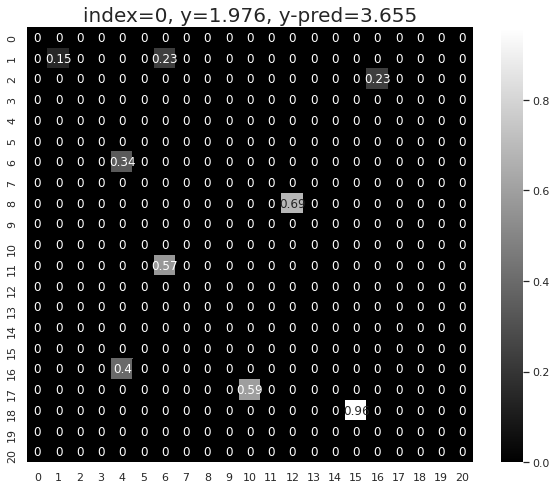

In [71]:
# root_dir = './data/805test_crop_single'
root_dir = './data/805test_crop_multi_radius20_pro'
test_sensor_input_dataset = SensorInputDataset(root_dir=root_dir, transform=tf)
test_sensor_input_dataloader = DataLoader(test_sensor_input_dataset, batch_size=16, shuffle=True, num_workers=3)

device = torch.device('cuda')
model = PowerPredictor5()
model.load_state_dict(torch.load('model/predictor5-9.24-0.2366.pt'))
model = model.to(device)
model.eval()

deltas = []
power_trues = []
power_preds = []

def one_sample(idx):
    device = torch.device('cuda')
#     sample = train_sensor_input_dataset[idx]
    sample = test_sensor_input_dataset[idx]
    X = torch.as_tensor(sample['matrix'])
    X = X.unsqueeze(0).to(device)
    y = sample['power']
    y_pred = model(X)
    y_pred = y_pred.data.cpu().numpy()
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    sns.heatmap(X[0][0].data.cpu().numpy(), cmap='gray', annot=True)
    ax.set_title(f'index={idx}, y={y[0]:.4}, y-pred={y_pred[0][0]:.4}', fontsize=20)
    deltas.append(y_pred[0][0] - y[0])
    power_trues.append(y[0])
    power_preds.append(y_pred[0][0])
    loc = sample['target']
    print('Location:', loc)
    print('Power:', sample['power'])
    for close in sample['closeby']:
        print(f'closeby: ({close[0]:.2f}, {close[1]:.2f}), power={close[2]:.2f}, distance to center={distance(loc[0], loc[1], close[0], close[1]):.2f}')


for i in range(0, 1):
    one_sample(i)

# one_sample(26176)

print('delta mean abs', np.mean(np.abs(deltas)))
print('power true mean abs', np.mean(power_trues))
print('power pred mean abs', np.mean(power_preds))

### running all 118043 samples in 805test_crop_multi_radius20_pro

delta mean abs 1.464555

power true mean abs 3.0015845

power pred mean abs 4.4411845


In [66]:
a = [1.3054, 1.4211, 1.4959, 1.5408, 1.5717]
np.mean(a)

1.46698

In [45]:
def one_sample_stats(idx, model):
    '''return (density, error, abs_error)
    '''
    device = torch.device('cuda')
    sample = test_sensor_input_dataset[idx]
    X = torch.as_tensor(sample['matrix'])
    X = X.unsqueeze(0).to(device)
    y = sample['power']
    y_pred = model(X)
    y_pred = y_pred.data.cpu().numpy()
    y_pred = y_pred[0][0]
    if len(y) != 1:
        raise('Error in length of y')
    y = y[0]     # the target's length must be one
    error = y_pred - y
    abs_error = np.absolute(error)
    X = X[0][0].data.cpu().numpy()
    num_sensors = np.count_nonzero(X)
    density = num_sensors / (21*21) * (100*100)
    if density < 300:
        density = 200
    elif density < 500:
        density = 400
    elif density < 700:
        density = 600
    elif density < 900:
        density = 800
    else:
        density = 1000
    return density, error, abs_error

## 5.1 PowerPredictor5 trained in logdistance

In [28]:
root_dir = './data/605test_crop'
test_sensor_input_dataset = SensorInputDataset(root_dir=root_dir, transform=tf)
test_sensor_input_dataloader = DataLoader(test_sensor_input_dataset, batch_size=16, shuffle=True, num_workers=3)

device = torch.device('cuda')
model = PowerPredictor5()
model.load_state_dict(torch.load('model/predictor5-9.24-0.2366.pt'))
model = model.to(device)
model.eval()

error_by_density = defaultdict(list)
abserror_by_density = defaultdict(list)
for i in range(0, 3200 * 10):
    if i % 3200 == 0:
        print(i, end='  ')
    density, error, abs_error = one_sample_stats(i, model)
    error_by_density[density].append(error)
    abserror_by_density[density].append(abs_error)

print()
X = [200, 400, 600, 800, 1000]
y_abs = []
y = []
for density, abserror in sorted(abserror_by_density.items()):
    y_abs.append(round(np.mean(abserror), 4))
    
for density, error in sorted(error_by_density.items()):
    y.append(round(np.mean(error), 4))
    
print(y_abs, y)

0  3200  6400  9600  12800  16000  19200  22400  25600  28800  
[0.3386, 0.2387, 0.2092, 0.1923, 0.1993] [-0.0068, -0.0229, -0.0017, 0.0201, -0.0077]


## 5.2 PowerPredictor5 trained in splat

In [320]:
device = torch.device('cuda')
model = PowerPredictor5()
model.load_state_dict(torch.load('model/predictor5-9.25-splat-0.1562.pt'))
model = model.to(device)
model.eval()

error_by_density = defaultdict(list)
abserror_by_density = defaultdict(list)
for i in range(0, 3200 * 10):
    if i % 3200 == 0:
        print(i, end='  ')
    density, error, abs_error = one_sample_stats(i, model)
    error_by_density[density].append(error)
    abserror_by_density[density].append(abs_error)

print()
X = [200, 400, 600, 800, 1000]
y_abs = []
y = []
for density, abserror in sorted(abserror_by_density.items()):
    y_abs.append(round(np.mean(abserror), 4))
    
for density, error in sorted(error_by_density.items()):
    y.append(round(np.mean(error), 4))
    
print(y_abs, y)

0  3200  6400  9600  12800  16000  19200  22400  25600  28800  
[0.2154, 0.1551, 0.1402, 0.1289, 0.1384] [0.0105, 0.015, 0.0281, 0.0107, -0.0079]


Text(0, 0.5, 'Power Estimation Error (dBm)')

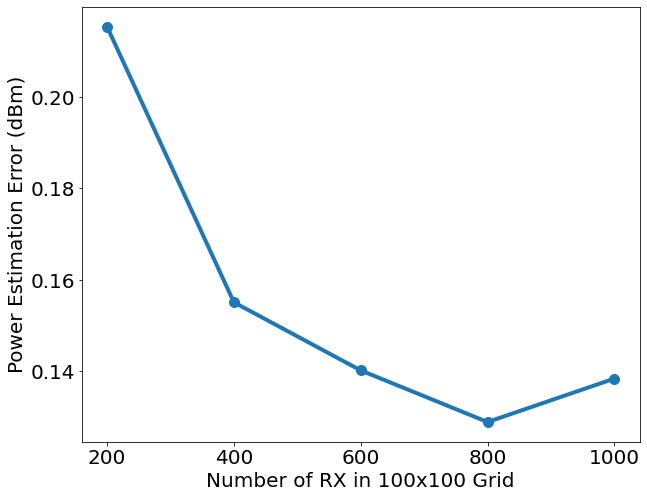

In [321]:
plt.rcParams['font.size'] = 20

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(X, y_abs, linewidth=4, marker='o', markersize=10)
ax.set_xticks([200, 400, 600, 800, 1000])
ax.set_xlabel('Number of RX in 100x100 Grid')
ax.set_ylabel('Power Estimation Error (dBm)')

## 5.3 PredPower in the crop single TX from the log-distance up-to-10 image

In [44]:
root_dir = './data/805test_crop_single_radius20'
test_sensor_input_dataset = SensorInputDataset(root_dir=root_dir, transform=tf)
test_sensor_input_dataloader = DataLoader(test_sensor_input_dataset, batch_size=16, shuffle=True, num_workers=3)

device = torch.device('cuda')
model = PowerPredictor5()
model.load_state_dict(torch.load('model/predictor5-9.24-0.2366.pt'))
model = model.to(device)
model.eval()

error_by_density = defaultdict(list)
abserror_by_density = defaultdict(list)
for i in range(0, 3200 * 10):
    try:
        if i % 3200 == 0:
            print(i, end='  ')
        density, error, abs_error = one_sample_stats(i, model)
        error_by_density[density].append(error)
        abserror_by_density[density].append(abs_error)
    except:
        print(f'error: no {i}')
        break
#     break
    
print()
X = [200, 400, 600, 800, 1000]
y_abs = []
y = []
for density, abserror in sorted(abserror_by_density.items()):
    y_abs.append(round(np.mean(abserror), 4))
    
for density, error in sorted(error_by_density.items()):
    y.append(round(np.mean(error), 4))
    
print(y_abs, y)

0  3200  6400  9600  12800  16000  19200  22400  25600  28800  
[0.3489, 0.2511, 0.2287, 0.2116, 0.2152] [0.0344, 0.0107, 0.0542, 0.0721, 0.0502]


root_dir = './data/805test_crop_single_radius10'

[0.5523, 0.5076, 0.5354, 0.5392, 0.5218] [0.3476, 0.3659, 0.4386, 0.4636, 0.4384]

root_dir = './data/805test_crop_single_radius20'

[0.3489, 0.2511, 0.2287, 0.2116, 0.2152] [0.0344, 0.0107, 0.0542, 0.0721, 0.0502]

root_dir = './data/805test_crop_single_radius30'

[0.3338, 0.2411, 0.2101, 0.1943, 0.1943] [-0.0157, -0.0362, 0.0013, 0.0279, 0.001]

root_dir = './data/605test_crop'

[0.3386, 0.2387, 0.2092, 0.1923, 0.1993] [-0.0068, -0.0229, -0.0017, 0.0201, -0.0077]

## 5.4 PredPower in the crop multi TX from the log-distance up-to-10 image

In [56]:
root_dir = './data/805test_crop_multi_radius20_pro'
test_sensor_input_dataset = SensorInputDataset(root_dir=root_dir, transform=tf)
test_sensor_input_dataloader = DataLoader(test_sensor_input_dataset, batch_size=16, shuffle=True, num_workers=3)

device = torch.device('cuda')
model = PowerPredictor5()
model.load_state_dict(torch.load('model/predictor5-9.24-0.2366.pt'))
model = model.to(device)
model.eval()

error_by_density = defaultdict(list)
abserror_by_density = defaultdict(list)
for i in range(0, 3200 * 100):
    try:
        if i % 3200 == 0:
            print(i, end='  ')
        density, error, abs_error = one_sample_stats(i, model)
        error_by_density[density].append(error)
        abserror_by_density[density].append(abs_error)
    except:
        print(f'error: no {i}')
        break
        
print()
X = [200, 400, 600, 800, 1000]
y_abs = []
y = []
for density, abserror in sorted(abserror_by_density.items()):
    y_abs.append(round(np.mean(abserror), 4))
    
for density, error in sorted(error_by_density.items()):
    y.append(round(np.mean(error), 4))

print(y_abs, y)

0  3200  6400  9600  12800  16000  19200  22400  25600  28800  32000  35200  38400  41600  44800  48000  51200  54400  57600  60800  64000  67200  70400  73600  76800  80000  83200  86400  89600  92800  96000  99200  102400  105600  108800  112000  115200  error: no 118043

[1.3054, 1.4211, 1.4959, 1.5408, 1.5717] [1.244, 1.3975, 1.4808, 1.5309, 1.5591]


root_dir = './data/805test_crop_multi_radius10'

[2.0168, 2.255, 2.3666, 2.4386, 2.4742] [2.008, 2.2545, 2.3663, 2.4383, 2.4742]

root_dir = './data/805test_crop_multi_radius20'

[1.2896, 1.413, 1.4862, 1.5572, 1.5702] [1.2254, 1.39, 1.472, 1.5477, 1.5587]

root_dir = './data/805test_crop_multi_radius30'

[1.0845, 1.1681, 1.2351, 1.2819, 1.2735] [0.9766, 1.1047, 1.1918, 1.2488, 1.2376]

# 6 Processing Data

In [58]:
def distance(x, y, a, b):
    return math.sqrt((x - a)**2 + (y - b)**2)

## 6.1 Crop the data

In [305]:
input_folder = 'data/705test'
output_folder = 'data/705test_crop'
if os.path.exists(output_folder) is False:
    os.mkdir(output_folder)

counter = 0
for folder in sorted(glob.glob(f'{input_folder}/*')):
    if counter % 2000 == 0:
        print(int(counter / 10), end='  ')
    num_samples = len(glob.glob(f'{folder}/*.json'))
    for i in range(num_samples):
        full_matrix_path = f'{folder}/{i}.npy'
        target_path = f'{folder}/{i}.target.npy'
#         print(full_matrix_path, target_path)
        full_matrix = np.load(full_matrix_path)
        target = np.load(target_path)
#         fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#         sns.heatmap(full_matrix, cmap='gray')
#         print(target)
        x, y = int(target[0][0]), int(target[0][1])
        crop = full_matrix[x-10:x+11, y-10:y+11]
#         fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#         sns.heatmap(crop, cmap='gray')
        np.save(f'{output_folder}/{counter}.npy', crop)
        np.save(f'{output_folder}/{counter}.target.npy', target)
        shutil.copy(f'{folder}/{i}.power.npy', f'{output_folder}/{counter}.power.npy')
        shutil.copy(f'{folder}/{i}.json', f'{output_folder}/{counter}.json')
        counter += 1
#     break

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000


## 6.2 Crop the data and then split into two parts: single TX, and multi TX(has close by TX)

In [46]:
input_folder = 'data/805test'
output_folder_single = 'data/805test_crop_single_radius20'
output_folder_multi = 'data/805test_crop_multi_radius20'
if os.path.exists(output_folder_single) is False:
    os.mkdir(output_folder_single)
if os.path.exists(output_folder_multi) is False:
    os.mkdir(output_folder_multi)


counter_single = 0
counter_multi = 0
for folder in sorted(glob.glob(f'{input_folder}/*')):
    num_samples = len(glob.glob(f'{folder}/*.json'))
    for i in range(num_samples):
        full_matrix_path = f'{folder}/{i}.npy'
        target_path = f'{folder}/{i}.target.npy'
        power_path = f'{folder}/{i}.power.npy'
#         print(full_matrix_path, ',',  target_path)
        full_matrix = np.load(full_matrix_path)
        targets = np.load(target_path)
        powers = np.load(power_path)
#         print('target length:', len(targets))
#         print('powers length:', len(powers))
#         fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#         sns.heatmap(full_matrix, cmap='gray')
        for j in range(len(targets)):
            x, y = int(targets[j][0]), int(targets[j][1])
            crop = full_matrix[x - 10: x + 11, y - 10: y + 11]
#             fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#             sns.heatmap(crop, cmap='gray', annot=True)
#             ax.set_title(f'({x}, {y})')
            has_close_by = False
            for k in range(len(targets)):
                if k == j:
                    continue
                a, b = int(targets[k][0]), int(targets[k][1])
                if np.abs(x - a) <= 20 and np.abs(y - b) <= 20:
                    has_close_by = True
                    break
            if has_close_by:
                np.save(f'{output_folder_multi}/{counter_multi}.npy', crop)
                np.save(f'{output_folder_multi}/{counter_multi}.target.npy', targets[j])
                np.save(f'{output_folder_multi}/{counter_multi}.power.npy', np.expand_dims(powers[j], 0))
                shutil.copy(f'{folder}/{i}.json', f'{output_folder_multi}/{counter_multi}.json')  # not useful, keep it for length/4
                counter_multi += 1
#                 print('multi', x, y)
            else:
                np.save(f'{output_folder_single}/{counter_single}.npy', crop)
                np.save(f'{output_folder_single}/{counter_single}.target.npy', targets[j])
                np.save(f'{output_folder_single}/{counter_single}.power.npy', np.expand_dims(powers[j], 0))
                shutil.copy(f'{folder}/{i}.json', f'{output_folder_single}/{counter_single}.json')
                counter_single += 1
#                 print('single', x, y)
#             break
#         break
#     break

In [54]:
multi_samples = len(glob.glob(f'{output_folder_multi}/*.json'))
single_samples = len(glob.glob(f'{output_folder_single}/*.json'))
print('multi samples', multi_samples)
print('single samples', single_samples)
print('average TX number per sample', (multi_samples + single_samples) / 32000)

multi samples 118043
single samples 57204
average TX number per sample 5.47646875


## 6.3 Crop the data and only save the transmitters with close-by TX and save the close-by TX information (Pro)

In [120]:
radius = 20

input_folder = 'data/805test'
# output_folder_single = f'data/805test_crop_single_radius{radius}_pro'
output_folder_multi = f'data/805test_crop_multi_radius{radius}_pro'
# if os.path.exists(output_folder_single) is False:
#     os.mkdir(output_folder_single)
if os.path.exists(output_folder_multi) is False:
    os.mkdir(output_folder_multi)


counter_single = 0
counter_multi = 0
for folder in sorted(glob.glob(f'{input_folder}/*')):
    num_samples = len(glob.glob(f'{folder}/*.json'))
    for i in range(num_samples):
        full_matrix_path = f'{folder}/{i}.npy'
        target_path = f'{folder}/{i}.target.npy'
        power_path = f'{folder}/{i}.power.npy'
#         print(full_matrix_path, ',',  target_path)
        full_matrix = np.load(full_matrix_path)
        targets = np.load(target_path)
        powers = np.load(power_path)
#         print('target length:', len(targets))
#         print('powers length:', len(powers))
#         fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#         sns.heatmap(full_matrix, cmap='gray')
        for j in range(len(targets)):
            x, y = int(targets[j][0]), int(targets[j][1])
            crop = full_matrix[x - 10: x + 11, y - 10: y + 11]
            close_by = []
#             fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#             sns.heatmap(crop, cmap='gray', annot=True)
#             ax.set_title(f'({x}, {y})')
            has_close_by = False
            for k in range(len(targets)):
                if k == j:
                    continue
                a, b = int(targets[k][0]), int(targets[k][1])
                if np.abs(x - a) <= radius and np.abs(y - b) <= radius:
                    has_close_by = True
                    close_by.append([targets[k][0], targets[k][1], powers[k]])
            if has_close_by:
                np.save(f'{output_folder_multi}/{counter_multi}.npy', crop)
                np.save(f'{output_folder_multi}/{counter_multi}.target.npy', targets[j])
                np.save(f'{output_folder_multi}/{counter_multi}.power.npy', np.expand_dims(powers[j], 0))
                np.save(f'{output_folder_multi}/{counter_multi}.closeby.npy', np.array(close_by))
                counter_multi += 1
#                 print('multi', x, y)
            else:
                continue
                np.save(f'{output_folder_single}/{counter_single}.npy', crop)
                np.save(f'{output_folder_single}/{counter_single}.target.npy', targets[j])
                np.save(f'{output_folder_single}/{counter_single}.power.npy', np.expand_dims(powers[j], 0))
                shutil.copy(f'{folder}/{i}.json', f'{output_folder_single}/{counter_single}.json')
                counter_single += 1
#                 print('single', x, y)
#             break
#         break
#     break

In [70]:
i = 0
print(np.load(f'data/805test_crop_multi_radius20_pro/{i}.target.npy'))
print(np.load(f'data/805test_crop_multi_radius20_pro/{i}.power.npy'))
print(np.load(f'data/805test_crop_multi_radius20_pro/{i}.closeby.npy'))

[10.682179 10.390335]
[1.9761342]
[[17.877     13.448158   0.8910125]]


In [73]:
distance(10.682179, 10.390335, 17.877, 13.448158)

7.817655065386933

## 6.4 Create a table dataset. The head is y, y', y'-y, y1', d1, y1'/d, y2', d2, y2'/d, ...

In [89]:
def pred(model, crop_img, debug=False):
    '''given an 21x21 cropped img, return the predicted the power
    '''
    device = torch.device('cuda')
    crop_img_copy = copy.deepcopy(crop_img)
    crop_img_copy = tf(crop_img_copy)
    X = torch.as_tensor(crop_img_copy)
    X = X.unsqueeze(0).to(device)  # from (21, 21) to (1, 1, 21, 21)
    y_pred = model(X)
    y_pred = y_pred.data.cpu().numpy()
    y_pred = y_pred[0][0]
    if debug:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        sns.heatmap(X[0][0].data.cpu().numpy(), cmap='gray', annot=True)
        ax.set_title(f'y-pred={y_pred:.4}', fontsize=20)
    return y_pred


def add_power(power_dict, key, crop_img, model):
    if key not in power_dict:
        pred_power = pred(model, crop_img, debug=False)
        power_dict[key] = pred_power

        
def get_power(power_dict, key):
    return power_dict[key]

In [97]:
device = torch.device('cuda')
model = PowerPredictor5()
model.load_state_dict(torch.load('model/predictor5-9.24-0.2366.pt'))
model = model.to(device)
model.eval()

radius = 20

input_folder = 'data/805train'
dataset = []

for folder in sorted(glob.glob(f'{input_folder}/*')):
    num_samples = len(glob.glob(f'{folder}/*.json'))  # number of samples per label, i.e. 5 or 10
    for i in range(num_samples):
        full_matrix_path = f'{folder}/{i}.npy'
        target_path = f'{folder}/{i}.target.npy'
        power_path = f'{folder}/{i}.power.npy'
#         print(full_matrix_path, ',',  target_path)
        full_matrix = np.load(full_matrix_path)
        targets = np.load(target_path)
        powers = np.load(power_path)
#         print('target length:', len(targets))
#         print('powers length:', len(powers))
        
#         fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#         sns.heatmap(full_matrix, cmap='gray')
#         ax.set_title('caitao-1')
        
        power_dict = {}                                    # (x, y) --> power_pred
        for j in range(len(targets)):                      # multiple targets in an image (sample)
            x, y = int(targets[j][0]), int(targets[j][1])
            close_by = []
#             fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#             sns.heatmap(crop, cmap='gray', annot=True)
#             ax.set_title(f'({x}, {y})')
            has_close_by = False
            for k in range(len(targets)):
                if k == j:
                    continue
                a, b = int(targets[k][0]), int(targets[k][1])
                if np.abs(x - a) <= radius and np.abs(y - b) <= radius:
                    has_close_by = True
                    dist = round(distance(targets[j][0], targets[j][1], targets[k][0], targets[k][1]), 4)
                    close_by.append([dist, int(targets[k][0]), int(targets[k][1])])
                    crop = full_matrix[a - 10: a + 11, b - 10: b + 11]
                    add_power(power_dict, (a, b), crop, model)
            if has_close_by:
#                 fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#                 sns.heatmap(full_matrix, cmap='gray')
#                 ax.set_title('caitao-2')
                
                crop = full_matrix[x - 10: x + 11, y - 10: y + 11]
                add_power(power_dict, (x, y), crop, model)
                true_power = powers[j]
                pred_power = get_power(power_dict, (x, y))
                one_entry = [f'{folder}-{i}', round(pred_power - true_power, 5), round(pred_power, 5), round(true_power, 5)]
                for dist, a, b in sorted(close_by):
                    pred_power = get_power(power_dict, (int(a), int(b)))
                    one_entry.extend([round(dist, 5), round(pred_power, 5), round(pred_power / dist, 5), round(pred_power / (dist**2), 5)])
                dataset.append(one_entry)
#                 break
#         break
#     break

# print(dataset)
# print(power_dict)

In [98]:
len(dataset)

237154

In [99]:
mydict = defaultdict(int)
for row in dataset:
    mydict[len(row)] += 1
    if len(row) == 36:
        print(row)
    
mydict

['data/805train/000987-6', 2.76525, 6.70484, 3.93959, 6.9477, 8.34521, 1.20115, 0.17288, 10.1503, 6.7227, 0.66232, 0.06525, 14.6036, 6.14229, 0.4206, 0.0288, 16.4267, 6.8155, 0.4149, 0.02526, 16.8507, 5.67074, 0.33653, 0.01997, 17.9925, 6.61253, 0.36752, 0.02043, 20.7475, 5.90782, 0.28475, 0.01372, 24.438, 4.6784, 0.19144, 0.00783]
['data/805train/002751-2', 2.38612, 4.81002, 2.4239, 8.5759, 5.94518, 0.69324, 0.08084, 12.4001, 5.78738, 0.46672, 0.03764, 17.3411, 5.00645, 0.2887, 0.01665, 19.0634, 5.6105, 0.29431, 0.01544, 19.8198, 6.73804, 0.33996, 0.01715, 22.0873, 3.54114, 0.16032, 0.00726, 23.4072, 6.63275, 0.28336, 0.01211, 24.4061, 2.99917, 0.12289, 0.00504]
['data/805train/004196-9', 4.43408, 7.11582, 2.68174, 5.6469, 8.92559, 1.58062, 0.27991, 7.4065, 5.28198, 0.71315, 0.09629, 12.2079, 7.53868, 0.61753, 0.05058, 15.5775, 5.10335, 0.32761, 0.02103, 17.6366, 5.52235, 0.31312, 0.01775, 18.2305, 4.46421, 0.24488, 0.01343, 20.1674, 4.70426, 0.23326, 0.01157, 22.3008, 5.69396, 0.2553

defaultdict(int,
            {8: 117652,
             12: 73024,
             24: 2667,
             16: 32723,
             20: 10607,
             28: 428,
             32: 50,
             36: 3})

In [100]:
fields = ['indx', 'delta', 'y_pred', 'y_true', 
          'distance_1', 'y1_pred', 'y1_pred/dist', 'y1_pred/dist^2',
          'distance_2', 'y2_pred', 'y2_pred/dist', 'y2_pred/dist^2',
          'distance_3', 'y3_pred', 'y3_pred/dist', 'y3_pred/dist^2',
          'distance_4', 'y4_pred', 'y4_pred/dist', 'y4_pred/dist^2',
          'distance_5', 'y5_pred', 'y5_pred/dist', 'y5_pred/dist^2']

filename = 'data/805train_multi_closeby.csv'

In [101]:
with open(filename, 'w') as f:
    write = csv.writer(f)
    write.writerow(fields)
    for row in dataset:
        if len(row) <= 24:
            write.writerow(row)

## Read the CSV dataset

In [102]:
filename = 'data/805train_multi_closeby.csv'
df_train = pd.read_csv(filename)
df_train.describe(include='all')

,indx,delta,y_pred,y_true,distance_1,y1_pred,y1_pred/dist,y1_pred/dist^2,distance_2,y2_pred,...,y3_pred/dist,y3_pred/dist^2,distance_4,y4_pred,y4_pred/dist,y4_pred/dist^2,distance_5,y5_pred,y5_pred/dist,y5_pred/dist^2
count,236673,236673.000000,236673.000000,236673.00000,236673.000000,236673.000000,236673.000000,236673.000000,119021.000000,119021.000000,...,45997.000000,45997.000000,13274.000000,13274.000000,13274.000000,13274.000000,2667.000000,2667.000000,2667.000000,2667.000000
unique,46902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,data/805train/002118-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.439384,4.441774,3.00239,12.854053,4.732996,0.604834,0.280340,16.931359,4.666592,...,0.265733,0.016477,20.546072,4.733378,0.240698,0.012747,21.700771,4.737742,0.225845,0.011095
std,NaN,1.223002,1.398317,1.44327,5.830014,1.372680,1.151834,12.133665,4.774806,1.386770,...,0.132515,0.020292,3.458797,1.378893,0.094129,0.008131,3.139635,1.379089,0.084769,0.006512
min,NaN,-1.883510,0.444830,0.50004,0.046700,0.444830,0.017570,0.000690,0.571600,0.490290,...,0.024790,0.000880,6.222300,0.552620,0.020370,0.000750,8.567700,0.781010,0.028940,0.001070
25%,NaN,0.509420,3.490760,1.75423,8.348400,3.861980,0.237320,0.013530,13.714500,3.759380,...,0.186820,0.008660,18.364375,3.862605,0.180542,0.007980,19.746550,3.839120,0.172645,0.007280
50%,NaN,1.148030,4.634850,3.00200,12.776400,4.920500,0.367470,0.028090,17.324500,4.846980,...,0.248670,0.012610,20.543350,4.923605,0.235645,0.011200,21.605100,4.933930,0.221330,0.010000
75%,NaN,2.130460,5.436080,4.24992,17.303100,5.691450,0.647870,0.076740,20.253800,5.627660,...,0.318090,0.018490,22.913775,5.685770,0.291775,0.015317,23.910300,5.696430,0.273670,0.013505


In [103]:
filename = 'data/805test_multi_closeby.csv'
df_test = pd.read_csv(filename)
df_test.describe(include='all')

,indx,delta,y_pred,y_true,distance_1,y1_pred,y1_pred/dist,y1_pred/dist^2,distance_2,y2_pred,...,y3_pred/dist,y3_pred/dist^2,distance_4,y4_pred,y4_pred/dist,y4_pred/dist^2,distance_5,y5_pred,y5_pred/dist,y5_pred/dist^2
count,117767,117767.000000,117767.000000,117767.000000,117767.000000,117767.000000,117767.000000,117767.000000,58832.000000,58832.000000,...,22492.000000,22492.000000,6496.000000,6496.000000,6496.000000,6496.000000,1283.000000,1283.000000,1283.000000,1283.000000
unique,23375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,data/805test/005100-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.435869,4.437441,3.001572,12.835258,4.724261,0.605863,0.257634,16.957502,4.646385,...,0.265505,0.016241,20.540791,4.746702,0.240840,0.012711,21.649941,4.758814,0.226634,0.011067
std,NaN,1.228506,1.392456,1.442373,5.854177,1.366160,1.074186,9.337473,4.757619,1.386053,...,0.127293,0.016451,3.400003,1.374952,0.092821,0.008126,3.038952,1.394393,0.081527,0.005569
min,NaN,-1.549600,0.530240,0.500020,0.052100,0.590260,0.023880,0.000850,0.697400,0.530240,...,0.023780,0.000990,5.563900,0.621820,0.024960,0.001000,11.522000,0.830230,0.031440,0.001190
25%,NaN,0.504840,3.490755,1.752975,8.281800,3.856775,0.236735,0.013490,13.741925,3.732320,...,0.187607,0.008640,18.392475,3.852430,0.181003,0.008050,19.890900,3.925360,0.172545,0.007305
50%,NaN,1.144340,4.624930,2.998700,12.727700,4.907870,0.367580,0.028180,17.338800,4.829940,...,0.249100,0.012650,20.569950,4.896225,0.235865,0.011200,21.637700,4.971060,0.227900,0.010330
75%,NaN,2.129230,5.429275,4.251900,17.321050,5.679660,0.650035,0.077710,20.280550,5.610920,...,0.317893,0.018362,22.850875,5.696442,0.291888,0.015212,23.780900,5.710675,0.276455,0.013425


In [104]:
df_test.head()

,indx,delta,y_pred,y_true,distance_1,y1_pred,y1_pred/dist,y1_pred/dist^2,distance_2,y2_pred,...,y3_pred/dist,y3_pred/dist^2,distance_4,y4_pred,y4_pred/dist,y4_pred/dist^2,distance_5,y5_pred,y5_pred/dist,y5_pred/dist^2
0,data/805test/000000-0,1.67860,3.65473,1.97613,7.8177,4.54911,0.58190,0.07443,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,data/805test/000000-0,3.65809,4.54911,0.89101,7.8177,3.65473,0.46749,0.05980,15.8291,5.39644,...,0.29300,0.01547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,data/805test/000000-0,2.15971,4.07215,1.91244,4.7445,5.88222,1.23980,0.26131,20.0684,5.54802,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,data/805test/000000-0,4.48955,5.39644,0.90689,3.1518,5.54802,1.76027,0.55850,15.8291,4.54911,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,data/805test/000000-0,1.75115,5.54802,3.79687,3.1518,5.39644,1.71218,0.54324,18.9351,4.54911,...,0.20291,0.01011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


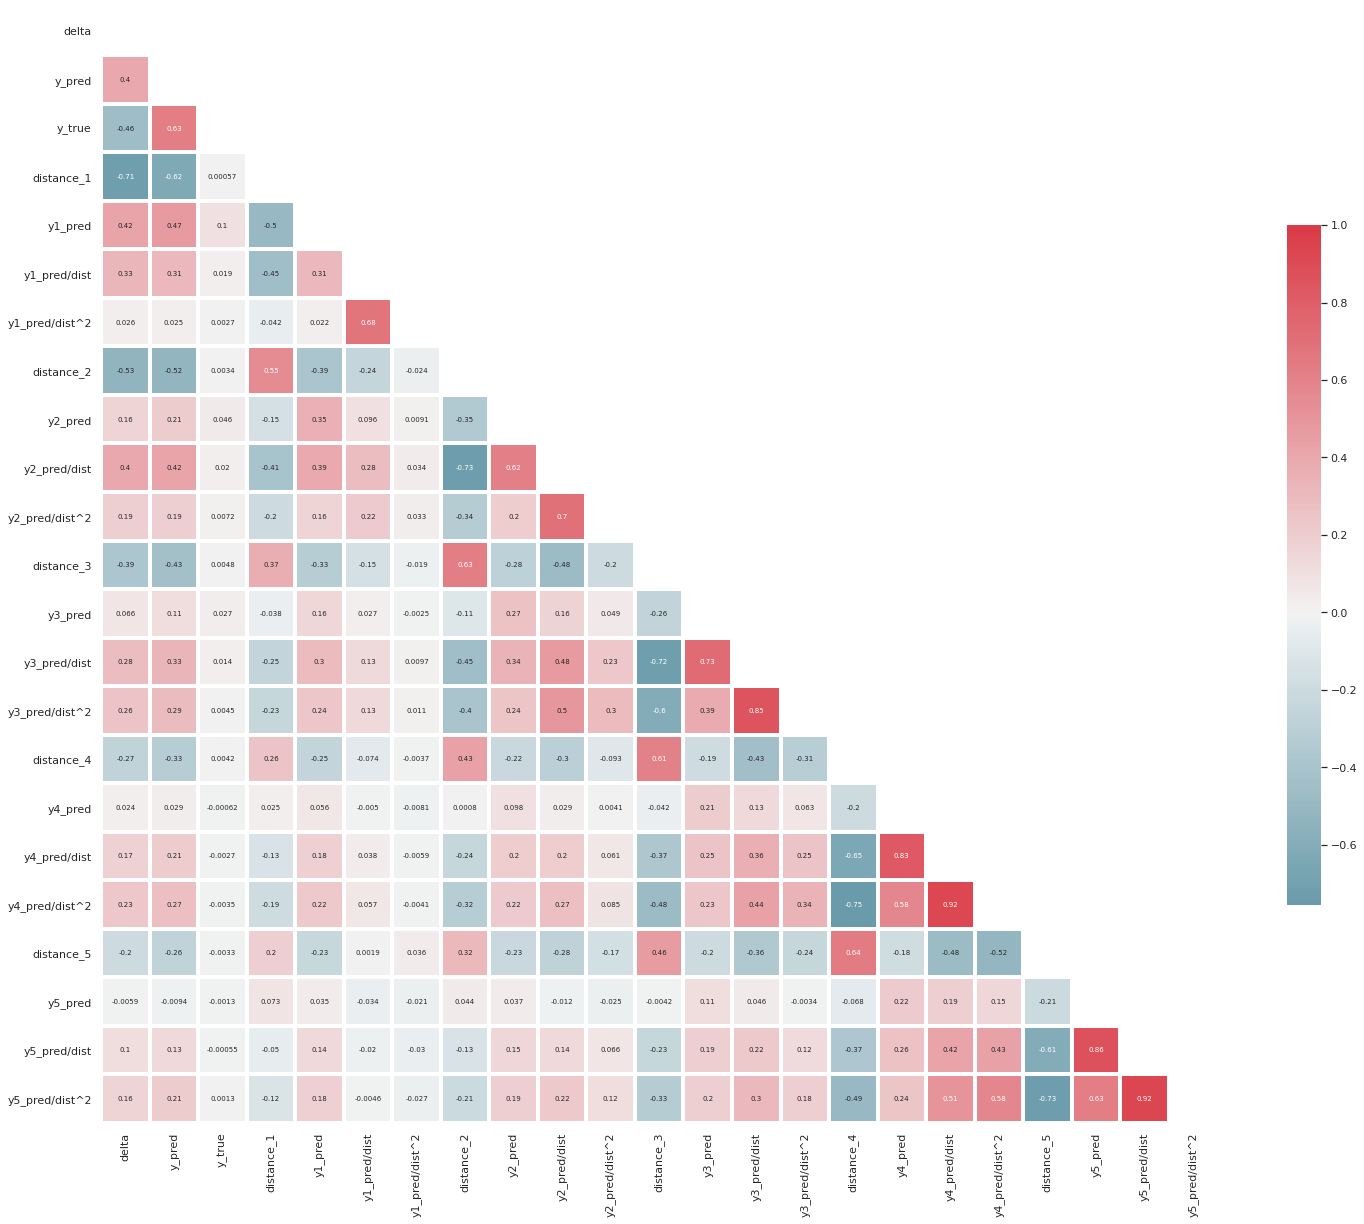

In [105]:
sns.set(style="white")

corr = df_train.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True, annot_kws={"size":7}, linewidth=3, cbar_kws={"shrink": .5})

f.savefig('data/805train_correlations.pdf')
plt.show()

In [106]:
train_target = df_train.loc[:, 'delta']
train_feature = df_train.iloc[:, 2:]
train_feature = train_feature.drop(columns=['y_true'])
train_feature

,y_pred,distance_1,y1_pred,y1_pred/dist,y1_pred/dist^2,distance_2,y2_pred,y2_pred/dist,y2_pred/dist^2,distance_3,...,y3_pred/dist,y3_pred/dist^2,distance_4,y4_pred,y4_pred/dist,y4_pred/dist^2,distance_5,y5_pred,y5_pred/dist,y5_pred/dist^2
0,3.31977,14.3165,1.18010,0.08243,0.00576,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.18010,14.3165,3.31977,0.23188,0.01620,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.40827,11.0945,3.96295,0.35720,0.03220,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.96295,11.0945,5.40827,0.48747,0.04394,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.69059,19.1057,3.53575,0.18506,0.00969,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236668,5.06617,13.1269,3.05423,0.23267,0.01772,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236669,1.85751,19.0753,4.91567,0.25770,0.01351,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236670,1.96901,19.2890,4.34823,0.22543,0.01169,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236671,4.91567,19.0753,1.85751,0.09738,0.00510,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Missing values: impute zero

In [107]:
new_train_feature = copy.deepcopy(train_feature)
for name in train_feature.columns:
    new_train_feature[name] = new_train_feature[name].fillna(value=0)

In [108]:
new_train_feature.describe()

,y_pred,distance_1,y1_pred,y1_pred/dist,y1_pred/dist^2,distance_2,y2_pred,y2_pred/dist,y2_pred/dist^2,distance_3,...,y3_pred/dist,y3_pred/dist^2,distance_4,y4_pred,y4_pred/dist,y4_pred/dist^2,distance_5,y5_pred,y5_pred/dist,y5_pred/dist^2
count,236673.000000,236673.000000,236673.000000,236673.000000,236673.000000,236673.000000,236673.000000,236673.000000,236673.000000,236673.000000,...,236673.000000,236673.000000,236673.000000,236673.000000,236673.000000,236673.000000,236673.000000,236673.000000,236673.000000,236673.000000
mean,4.441774,12.854053,4.732996,0.604834,0.280340,8.514648,2.346792,0.162698,0.014169,3.708501,...,0.051645,0.003202,1.152343,0.265475,0.013500,0.000715,0.244540,0.053388,0.002545,0.000125
std,1.398317,5.830014,1.372680,1.151834,12.133665,9.117615,2.532042,0.230900,0.069296,7.754843,...,0.120289,0.011070,4.797838,1.136994,0.059699,0.003509,2.314727,0.521070,0.025480,0.001360
min,0.444830,0.046700,0.444830,0.017570,0.000690,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.490760,8.348400,3.861980,0.237320,0.013530,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.634850,12.776400,4.920500,0.367470,0.028090,4.636500,1.181090,0.052540,0.002260,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.436080,17.303100,5.691450,0.647870,0.076740,17.360500,4.857510,0.274330,0.015440,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.014360,29.424900,10.014360,146.477450,2800.715980,29.355700,10.014360,11.909150,20.834770,29.424900,...,3.455780,1.467420,29.355700,9.285340,1.082090,0.163710,28.906200,8.691970,0.917370,0.107070


### Linear Regression

In [109]:
model = linear_model.LinearRegression()
model = model.fit(new_train_feature, train_target)
for name, coef in zip(new_train_feature.columns, model.coef_):
    print(f'name = {name:<15}, coef = {coef:.4f}')
print('score on training', model.score(new_train_feature, train_target))

test_target = df_test.loc[:, 'delta']
test_feature = df_test.iloc[:, 2:]
test_feature = test_feature.drop(columns=['y_true'])
test_feature

new_test_feature = copy.deepcopy(test_feature)
for name in test_feature.columns:
    new_test_feature[name] = new_test_feature[name].fillna(value=0)
    
print('score on testing ', model.score(new_test_feature, test_target))

delta_pred = model.predict(new_test_feature)

delta_true = df_test.delta.to_numpy()

print('absolute mean delta error =', np.mean(np.abs(delta_pred - delta_true)))
print('mean delta error =', np.mean(delta_pred - delta_true))
print('std delta error =', np.std(delta_pred - delta_true))

name = y_pred         , coef = -0.1464
name = distance_1     , coef = -0.1460
name = y1_pred        , coef = 0.0412
name = y1_pred/dist   , coef = -0.0314
name = y1_pred/dist^2 , coef = 0.0012
name = distance_2     , coef = 0.0016
name = y2_pred        , coef = -0.0549
name = y2_pred/dist   , coef = 1.7412
name = y2_pred/dist^2 , coef = -1.6050
name = distance_3     , coef = 0.0106
name = y3_pred        , coef = -0.1762
name = y3_pred/dist   , coef = 4.1072
name = y3_pred/dist^2 , coef = -13.7379
name = distance_4     , coef = 0.0007
name = y4_pred        , coef = -0.0907
name = y4_pred/dist   , coef = 3.1641
name = y4_pred/dist^2 , coef = -18.6443
name = distance_5     , coef = -0.0004
name = y5_pred        , coef = 0.0734
name = y5_pred/dist   , coef = -2.1626
name = y5_pred/dist^2 , coef = 16.1579
score on training 0.5762779447505011
score on testing  0.5676053934132077
absolute mean delta error = 0.6069403617129157
mean delta error = 0.002702093554311196
std delta error = 0.8078170

In [113]:
i = 0
for pred, true in zip(delta_pred, delta_true):
    print(f'pred={pred:.3f}, true={true:.3f}, true-pred={true-pred:.3f}')
    i += 1
    if i == 20:
        break

pred=2.084, true=1.679, true-pred=-0.406
pred=2.422, true=3.658, true-pred=1.236
pred=2.693, true=2.160, true-pred=-0.534
pred=2.762, true=4.490, true-pred=1.727
pred=2.857, true=1.751, true-pred=-1.106
pred=2.334, true=3.724, true-pred=1.390
pred=2.238, true=1.723, true-pred=-0.515
pred=2.179, true=1.570, true-pred=-0.609
pred=0.416, true=0.252, true-pred=-0.164
pred=2.312, true=2.497, true-pred=0.185
pred=0.555, true=0.869, true-pred=0.313
pred=2.307, true=3.490, true-pred=1.183
pred=0.169, true=0.394, true-pred=0.226
pred=3.130, true=4.259, true-pred=1.129
pred=0.275, true=0.460, true-pred=0.185
pred=2.906, true=5.391, true-pred=2.485
pred=2.420, true=0.707, true-pred=-1.712
pred=2.048, true=2.224, true-pred=0.176
pred=2.132, true=3.034, true-pred=0.902
pred=2.682, true=2.262, true-pred=-0.420


In [43]:
np.mean(np.abs(delta_true))

3.6111222017203457

### Ridge Regression

In [114]:
model = linear_model.Ridge(alpha=1.0)
model = model.fit(new_train_feature, train_target)
for name, coef in zip(new_train_feature.columns, model.coef_):
    print(f'name = {name:<15}, coef = {coef:.4f}')
print('score on training', model.score(new_train_feature, train_target))

test_target = df_test.loc[:, 'delta']
test_feature = df_test.iloc[:, 2:]
test_feature = test_feature.drop(columns=['y_true'])
test_feature

new_test_feature = copy.deepcopy(test_feature)
for name in test_feature.columns:
    new_test_feature[name] = new_test_feature[name].fillna(value=0)
    
print('score on testing ', model.score(new_test_feature, test_target))

delta_pred = model.predict(new_test_feature)

delta_true = df_test.delta.to_numpy()

print('absolute mean delta error =', np.mean(np.abs(delta_pred - delta_true)))
print('mean delta error =', np.mean(delta_pred - delta_true))
print('std delta error =', np.std(delta_pred - delta_true))

name = y_pred         , coef = -0.1460
name = distance_1     , coef = -0.1461
name = y1_pred        , coef = 0.0412
name = y1_pred/dist   , coef = -0.0314
name = y1_pred/dist^2 , coef = 0.0012
name = distance_2     , coef = 0.0013
name = y2_pred        , coef = -0.0541
name = y2_pred/dist   , coef = 1.7505
name = y2_pred/dist^2 , coef = -1.6418
name = distance_3     , coef = 0.0088
name = y3_pred        , coef = -0.1336
name = y3_pred/dist   , coef = 3.1971
name = y3_pred/dist^2 , coef = -9.5620
name = distance_4     , coef = 0.0005
name = y4_pred        , coef = -0.0277
name = y4_pred/dist   , coef = 1.0073
name = y4_pred/dist^2 , coef = -0.3383
name = distance_5     , coef = 0.0001
name = y5_pred        , coef = 0.0331
name = y5_pred/dist   , coef = -0.5334
name = y5_pred/dist^2 , coef = -0.0846
score on training 0.5761349168152647
score on testing  0.567321862110163
absolute mean delta error = 0.6071707244768834
mean delta error = 0.0027155903731371596
std delta error = 0.8080818423

### Lasso

In [115]:
model = linear_model.Lasso(alpha=0.01)
model = model.fit(new_train_feature, train_target)
for name, coef in zip(new_train_feature.columns, model.coef_):
    print(f'name = {name:<15}, coef = {coef:.4f}')
print('score on training', model.score(new_train_feature, train_target))

test_target = df_test.loc[:, 'delta']
test_feature = df_test.iloc[:, 2:]
test_feature = test_feature.drop(columns=['y_true'])
test_feature

new_test_feature = copy.deepcopy(test_feature)
for name in test_feature.columns:
    new_test_feature[name] = new_test_feature[name].fillna(value=0)
    
print('score on testing ', model.score(new_test_feature, test_target))

delta_pred = model.predict(new_test_feature)

delta_true = df_test.delta.to_numpy()

print('absolute mean delta error =', np.mean(np.abs(delta_pred - delta_true)))
print('mean delta error =', np.mean(delta_pred - delta_true))
print('std delta error =', np.std(delta_pred - delta_true))

name = y_pred         , coef = -0.1201
name = distance_1     , coef = -0.1462
name = y1_pred        , coef = 0.0302
name = y1_pred/dist   , coef = -0.0000
name = y1_pred/dist^2 , coef = -0.0006
name = distance_2     , coef = -0.0142
name = y2_pred        , coef = 0.0854
name = y2_pred/dist   , coef = 0.2656
name = y2_pred/dist^2 , coef = 0.0000
name = distance_3     , coef = -0.0024
name = y3_pred        , coef = 0.0531
name = y3_pred/dist   , coef = 0.0000
name = y3_pred/dist^2 , coef = 0.0000
name = distance_4     , coef = 0.0048
name = y4_pred        , coef = 0.0091
name = y4_pred/dist   , coef = 0.0000
name = y4_pred/dist^2 , coef = 0.0000
name = distance_5     , coef = 0.0052
name = y5_pred        , coef = 0.0000
name = y5_pred/dist   , coef = 0.0000
name = y5_pred/dist^2 , coef = 0.0000
score on training 0.5645080561678658
score on testing  0.5559438843926117
absolute mean delta error = 0.6171691328479219
mean delta error = 0.0035999399685617654
std delta error = 0.81863451866997